In [245]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, plot_confusion_matrix, log_loss, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold, RandomizedSearchCV
pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [246]:
#read in the data using low memory
df = pd.read_csv('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/data/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)
#drop when the play is the last of the quarter
df = df[df['quarter_end'] == 0]
#grab all 4th downs
df_4 = df[df['down'] == 4.0]
#convert date to datetime
date = pd.to_datetime(df_4['game_date'].values)
#separate date and year
df_4['game_date'] = date
df_4['year'] = date.year
df_4 = df_4[['yardline_100', 'year', 'half_seconds_remaining', 'drive', 'qtr', 'play_type']]
df_4.loc[df_4['play_type'] == 'punt', 'target'] = 1
df_4.loc[df_4['play_type'] != 'punt', 'target'] = 0

In [248]:
df_4.shape

(39644, 7)

In [171]:
#if working with RandomForests dont need to drop na, else dropna
test = df_4[df_4['year'] == 2018].dropna()
train = df_4[(df_4['year'] == 2017) | (df_4['year'] == 2016) | (df_4['year'] == 2015) | (df_4['year'] == 2014) | (df_4['year'] == 2013)].dropna()

y_test = test['target']
X_test = test.drop(columns=['target', 'play_type']) #.select_dtypes(exclude=['object'])

y_train = train['target']
X_train = train.drop(columns=['target', 'play_type']) #.select_dtypes(exclude=['object'])

In [174]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_train)

array([1., 1., 1., ..., 0., 0., 1.])

In [175]:
def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True, random_state=123)  # almost always use shuffle=True
    acc_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)

        y_test_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_test_pred))

        #precision_scores.append(precision_score(y[test], y_test_pred))
        #test_matrix = confusion_matrix(y[test], y_test_pred)
    
    print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return model

In [104]:
cross_val(LogisticRegression(), X_train.values, y_train.values)

Accuracy Mean Score of LogisticRegression: 0.886


In [182]:
rf = cross_val(RandomForestClassifier(max_depth=5, min_samples_leaf), X_train.values, y_train.values)

Accuracy Mean Score of RandomForestClassifier: 0.904


In [234]:
arr = rf.feature_importances_

In [237]:
lst = []
for x in arr:
    lst.append(x)

<BarContainer object of 5 artists>

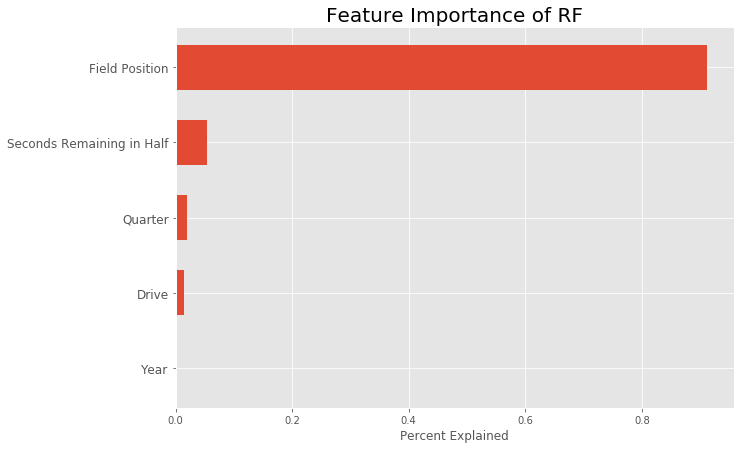

In [244]:
plt.figure(figsize=(10,7))
plt.title('Feature Importance of RF', size=20)
plt.xlabel('Percent Explained')
plt.yticks(size=12)
plt.barh(['Year', 'Drive','Quarter','Seconds Remaining in Half', 'Field Position'], sorted(lst), height=0.6)

In [185]:
# parameter space for randomized grid search
n_estimators = [50, 100, 200]
max_features = ['log2', 'sqrt', None]
max_depth = [2, 3, 6]
min_samples_split = [2, 4, 8]
min_samples_leaf = [1, 2, 4]
learning_rate  = [0.1, 0.05, 0.025]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
# create 20 gbc objects to be tuned and fitted
gbc = GradientBoostingClassifier()
clf = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 10, scoring='f1', n_jobs = -1, cv = 5, verbose=0)

In [188]:
clf.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [192]:
#use this for gradient boosting
clf.best_params_

{'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 3,
 'learning_rate': 0.1}

In [193]:
cross_val(GradientBoostingClassifier(n_estimators=50, min_samples_split=8, min_samples_leaf=4, max_features=None, max_depth=3, learning_rate=0.1), X_train.values, y_train.values)

Accuracy Mean Score of GradientBoostingClassifier: 0.904


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=8,
                           min_weight_fraction_leaf=0.0, n_estimators=50,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)